** 1. Load Data **

In [218]:
from pandas import Series, DataFrame
import pandas as pd
stocks = ['AAPL', 'AMZN', 'FB', 'GOOG', 'MSFT']
market = 'NASDAQ'
df = pd.read_csv("data/{}.csv".format(market), index_col='Date', 
                         parse_dates=True, usecols=['Date', 'Adj Close'], 
                         na_values =['nan'])
df = df.rename(columns={'Adj Close':market})
for stock in stocks:
    df_temp = pd.read_csv("data/{}.csv".format(stock), index_col='Date', 
                         parse_dates=True, usecols=['Date', 'Adj Close'], 
                         na_values =['nan'])
    df_temp = df_temp.rename(columns={'Adj Close':stock})
    df = df.join(df_temp)

print(df.shape)
df.head()

(504, 6)


,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2016-02-04,4509.560059,93.506599,536.260010,110.489998,708.010010,49.505825
2016-02-05,4363.140137,91.009224,502.130005,104.070000,683.570007,47.754078
2016-02-08,4283.750000,91.967522,488.100006,99.750000,682.739990,47.040047
2016-02-09,4268.759766,91.948151,482.070007,99.540001,678.109985,46.916283
2016-02-10,4283.589844,91.251221,490.480011,101.000000,684.119995,47.325657


** 2. Visualize Data **

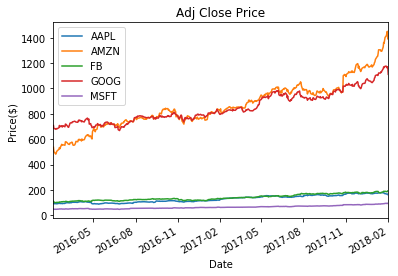

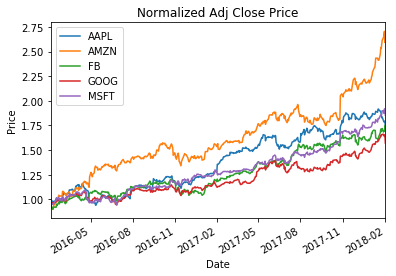

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

p1 = df[stocks].plot(title="Adj Close Price")
p1.set_xlabel("Date")
p1.set_ylabel("Price($)")
plt.show()

df_norm = df / df.iloc[0,:]
p2 = df_norm[stocks].plot(title="Normalized Adj Close Price")
p2.set_xlabel("Date")
p2.set_ylabel("Price($)")
plt.show()

** 3. Check for any missing data **

In [3]:
df.isnull().values.ravel().sum()

0

** 4. Create Features **

In [372]:
def cat(a,t):
    b = pd.DataFrame.copy(a)
    b[b >= t] = 1
    b[b <  t] = 0
    return b

In [373]:
def get_rolling_mean(data, window):
    return data.rolling(window=window,center=False).mean()

def get_rolling_std(data, window):
    return data.rolling(window=window,center=False).std()

def get_bollinger_bands(data, window):
    rm = get_rolling_mean(data, window)
    rstd = get_rolling_std(data, window)
    upper_band = rm + 2 * rstd
    lower_band = rm - 2 * rstd
    return rm, upper_band, lower_band, rstd

rm, ub, lb, rstd = get_bollinger_bands(df_norm, 20)

# above bollinger band or below bollinger band
ab = df_norm-ub
ab_ind = cat(ab,0)

bb = df_norm-lb
bb_ind = cat(bb,0)

# deviation from rolling mean
drm = df_norm - rm

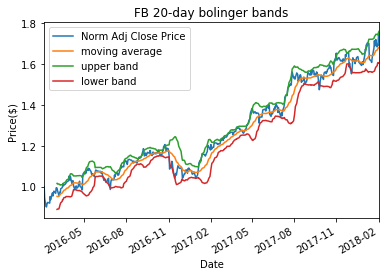

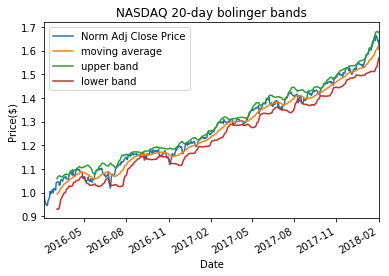

In [217]:
def plot_bollinger_bands(stock, window):
    p = df_norm[stock].plot(title=stock + ' ' + str(window) + '-day bolinger bands', 
                            label="Norm Adj Close Price")
    rm, ub, lb, rstd = get_bollinger_bands(df_norm[stock], window)
    rm.plot(label="moving average", ax = p)
    ub.plot(label="upper band", ax = p)
    lb.plot(label="lower band", ax = p)
    p.set_ylabel("Price($)")
    p.legend(loc='upper left')
    plt.show()

plot_bollinger_bands('FB', 20)
plot_bollinger_bands(market, 20)

In [374]:
def get_daily_return(data):
    daily_return = data / data.shift(1) - 1
    daily_return.iloc[0,:] = 0
    return daily_return
dr = get_daily_return(df_norm)
dr_ind = cat(dr,0)
dr.head()

,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2016-02-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2016-02-05,-0.032469,-0.026708,-0.063645,-0.058105,-0.034519,-0.035385
2016-02-08,-0.018196,0.010530,-0.027941,-0.041511,-0.001214,-0.014952
2016-02-09,-0.003499,-0.000211,-0.012354,-0.002105,-0.006782,-0.002631
2016-02-10,0.003474,-0.007580,0.017446,0.014667,0.008863,0.008726


In [268]:
def get_sharp_ratio(data, window):
    return np.sqrt(252) * get_rolling_mean(data, window) / get_rolling_std(data, window)
sr = get_sharp_ratio(df_norm, 60)
sr.tail()

,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2018-01-29,490.489969,948.646967,241.440767,693.355303,348.639050,437.238941
2018-01-30,482.815705,956.979857,228.527759,680.760704,340.041882,425.067870
2018-01-31,476.234520,956.139328,217.673939,669.987639,331.528561,402.769066
2018-02-01,470.535722,932.149190,213.594009,629.781853,324.171594,387.919801
2018-02-02,471.019054,819.374917,206.917673,609.819297,325.329971,382.777345


In [375]:
def get_momentum(data, window):
    momentum =  data / data.shift(window) - 1
    momentum.iloc[:window-1,:] = 0
    return momentum
mt = get_momentum(df_norm, 5)
mt.tail()

,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2018-01-29,0.007894,-0.051073,0.068085,0.003291,0.017105,0.025216
2018-01-30,-0.007749,-0.056880,0.055250,-0.011777,-0.005368,0.009140
2018-01-31,-0.000483,-0.038974,0.068788,0.001823,0.004896,0.034742
2018-02-01,-0.003414,-0.019461,0.008745,0.029923,-0.002281,0.020903
2018-02-02,-0.035282,-0.064194,0.019899,0.001474,-0.054378,-0.024240


In [376]:
rm_mt = get_momentum(rm, 5)
rm_mt.tail()

,NASDAQ,AAPL,AMZN,FB,GOOG,MSFT
Date,,,,,,
2018-01-29,0.017604,-0.000123,0.041612,0.014636,0.026416,0.020642
2018-01-30,0.017572,-0.001352,0.044530,0.014248,0.026786,0.021022
2018-01-31,0.017164,-0.002510,0.047090,0.013150,0.026697,0.022504
2018-02-01,0.016033,-0.003939,0.046108,0.012271,0.025281,0.022969
2018-02-02,0.013177,-0.007786,0.045734,0.010482,0.020616,0.020795


** 5. Prepare Data **

In [377]:
def get_data(stock):
    data = pd.concat([df_norm[stock], drm[stock], ab[stock], bb[stock], 
                      sr[stock], dr[stock], rm_mt[stock], drm[market]], axis=1)
    data.columns = ['norm price','price - rm', 'price - ub', 'price - lb', 
                    'sharp ratio', 'daily return', 
                    'rm momentum', 'market - market_rm']
    return data
X = {stock: get_data(stock) for stock in stocks}

In [378]:
stock = 'FB'

X_train = X[stock].loc['2016-04-29':'2017-08-31']
X_test  = X[stock].loc['2017-09-01':'2017-12-29']
X_train = X_train.reset_index(drop=True)
X_test  = X_test.reset_index(drop=True)

# continuous label
y_train = df_norm.loc['2016-05-02':'2017-09-01', stock]
y_test  = df_norm.loc['2017-09-05':'2018-01-02', stock]
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

# categorical label
y_train2 = y_train / X_train['norm price'] - 1
y_test2  = y_test / X_test['norm price'] - 1

y_train2 = np.asarray(cat(y_train2,0.01))
y_test2 = np.asarray(cat(y_test2,0.01))


In [382]:
#np.unique(y_train2, return_counts=True)
np.unique(y_test2, return_counts=True)

(array([ 0.,  1.]), array([68, 15], dtype=int64))

** Continuous label **

**** Descriptive Analysis ****

[[<matplotlib.axes._subplots.AxesSubplot object at 0x000001D983CA7438>


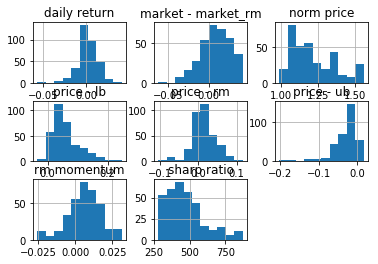

In [383]:
%matplotlib inline
print(X_train.hist())

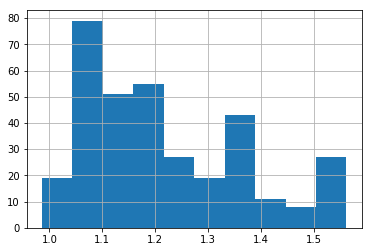

In [384]:
y_train.hist()

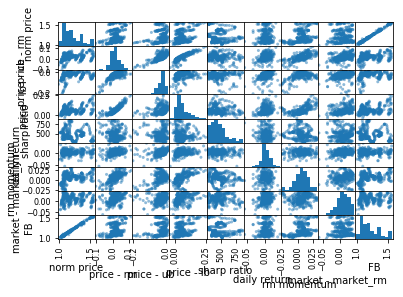

In [385]:
from pandas.plotting import scatter_matrix
scatter_matrix(pd.concat([X_train,y_train], axis=1))
plt.show()

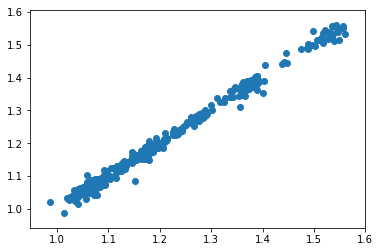

In [386]:
plt.scatter(X_train['norm price'], y_train)

** Linear Regression **

In [387]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
lr = linear_model.LinearRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

print("RMSE: %.2f" % mean_squared_error(y_test, y_pred))
print('R2: %.2f' % r2_score(y_test, y_pred))

RMSE: 0.00
R2: 0.76


** Decision Tree **

In [388]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
    
def fit_model(X, y):

    cv_sets = TimeSeriesSplit(n_splits=10)

    regressor = DecisionTreeRegressor()
    
    scoring_fnc = make_scorer(r2_score)

    params = {'max_depth': [1,2,3,4,5,6,7,8,9,10], 'min_samples_split': [10, 20]}

    grid = GridSearchCV(estimator=regressor, param_grid=params, scoring=scoring_fnc, cv=cv_sets)

    grid = grid.fit(X, y)

    return grid.best_estimator_

dtr = fit_model(X_train, y_train)

print(dtr.get_params())

y_pred = dtr.predict(X_test)

print("RMSE: %.2f" % mean_squared_error(y_test, y_pred))
print('R2: %.2f' % r2_score(y_test, y_pred))

{'criterion': 'mse', 'max_depth': 4, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'min_weight_fraction_leaf': 0.0, 'presort': False, 'random_state': None, 'splitter': 'best'}
RMSE: 0.02
R2: -11.41


In [389]:
from sklearn.tree import export_graphviz
import pydotplus
dot_data = export_graphviz(dtr, feature_names=list(X_train), filled=True, out_file=None)
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('tree.png')

True

** XGBoost **

In [390]:
import xgboost as xgb
gbm = xgb.XGBRegressor(max_depth=10, n_estimators=300, learning_rate=0.05)
gbm.fit(X_train, y_train)

y_pred = gbm.predict(X_test)

print("RMSE: %.2f" % mean_squared_error(y_test, y_pred))
print('R2: %.2f' % r2_score(y_test, y_pred))

RMSE: 0.01
R2: -2.67


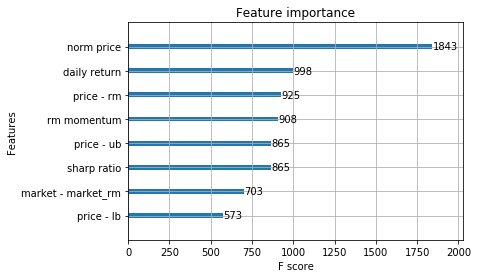

In [391]:
xgb.plot_importance(gbm)

** Logistic Regression **

In [407]:
# get net gain if make purchase decision based on the predicted closing price 
# at the begining of every day (buy if predict 1 and sell if predict 0)

def get_gain(y0,y_test,y_pred):
    gain = 0
    for i in range(len(y_test)):
        if i == 0:
            if y_pred[i] == 1:
                gain = y_test[i] - y0
        else:
            if y_pred[i] == 1:
                gain += y_test[i] - y_test[i-1]
    return gain

In [408]:
from sklearn import linear_model
from sklearn.metrics import accuracy_score, fbeta_score, classification_report
lr = linear_model.LogisticRegression()
lr.fit(X_train, y_train2)
y_pred2_lr = lr.predict(X_test)
accuracy_lr = accuracy_score(y_test2, y_pred2)
fscore_lr = fbeta_score(y_test2, y_pred2, beta = 0.5)
gain_lr = get_gain(X_test['norm price'][len(X_test)-1], y_test, y_pred2_lr)

print("Accuracy on test data: %.2f" % accuracy_lr)
print("F-score on test data: %.2f" % fscore_lr)
print("Net gain (normalized): %.2f" % gain_lr)
print(classification_report(y_test2, y_pred2))


Accuracy on test data: 0.82
F-score on test data: 0.00
Net gain (normalized): 0.00
             precision    recall  f1-score   support

        0.0       0.82      1.00      0.90        68
        1.0       0.00      0.00      0.00        15

avg / total       0.67      0.82      0.74        83



C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


** XGBoost **

In [409]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, fbeta_score
cv_sets = TimeSeriesSplit(n_splits = 10).split(X_train)
gbm = xgb.XGBClassifier(max_depth=5, n_estimators=500, learning_rate=0.05)
parameters = {'learning_rate': [0.05, 0.1, 0.2], 
              'n_estimators': [100, 200, 500], 
              'max_depth': [2, 3, 5]}
scorer = make_scorer(accuracy_score)
grid_obj = GridSearchCV(estimator=gbm, param_grid=parameters, scoring=scorer, cv=cv_sets)
grid_fit = grid_obj.fit(X_train, y_train2)
best_clf = grid_fit.best_estimator_
y_pred2_xgb = best_clf.predict(X_test)
accuracy_xgb = accuracy_score(y_test2, y_pred2_xgb)
fscore_xgb = fbeta_score(y_test2, y_pred2_xgb, beta = 0.5)
gain_xgb = get_gain(X_test['norm price'][len(X_test)-1], y_test, y_pred2_xgb)

print("Accuracy on test data: %.2f" % accuracy_xgb)
print("F-score on test data: %.2f" % fscore_xgb)
print("Net gain (normalized): %.2f" % gain_xgb)
print(classification_report(y_test2, y_pred2_xgb))

Accuracy on test data: 0.83
F-score on test data: 0.37
Net gain (normalized): 0.06
             precision    recall  f1-score   support

        0.0       0.84      0.99      0.91        68
        1.0       0.67      0.13      0.22        15

avg / total       0.81      0.83      0.78        83



** GBM **

In [423]:
from sklearn import ensemble, cross_validation, model_selection
from sklearn.metrics import make_scorer, fbeta_score, accuracy_score
#cv_sets = cross_validation.ShuffleSplit(X_train.shape[0], n_iter = 10, test_size = 0.20, random_state = 0)
cv_sets = model_selection.TimeSeriesSplit(n_splits = 10).split(X_train)
gbm2 = ensemble.GradientBoostingClassifier()
parameters = {'learning_rate': [0.05, 0.1, 0.2], 
              'n_estimators': [100, 200, 500], 
              'max_depth': [2, 3, 4]}
scorer = make_scorer(fbeta_score, beta=0.5)
#scorer = make_scorer(accuracy_score)
grid_obj = model_selection.GridSearchCV(estimator=gbm2, param_grid=parameters, scoring=scorer, cv=cv_sets)
grid_fit = grid_obj.fit(X_train, y_train2)
best_clf = grid_fit.best_estimator_
y_pred2_gbm = best_clf.predict(X_test)
accuracy_gbm = accuracy_score(y_test2, y_pred2_gbm)
fscore_gbm = fbeta_score(y_test2, y_pred2_gbm, beta = 0.5)
gain_gbm = get_gain(X_test['norm price'][len(X_test)-1], y_test, y_pred2_gbm)

print("Accuracy on test data: %.2f" % accuracy_gbm)
print("F-score on test data: %.2f" % fscore_gbm)
print("Net gain (normalized): %.2f" % gain_gbm)
print(classification_report(y_test2, y_pred2_gbm))

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: Undefined

C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\weife\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Accuracy on test data: 0.61
F-score on test data: 0.25
Net gain (normalized): 0.21
             precision    recall  f1-score   support

        0.0       0.85      0.65      0.73        68
        1.0       0.23      0.47      0.30        15

avg / total       0.73      0.61      0.66        83



In [414]:
y_pred2_naive = np.asarray([1 for i in range(len(y_test2))])

In [417]:
gain_naive = get_gain(X_test['norm price'][len(X_test)-1], y_test, y_pred2_naive)
gain_naive

0.044890859713835551

In [422]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_test2, y_pred2_gbm).ravel()
(tn, fp, fn, tp)

(53, 15, 10, 5)